In [13]:
import os
import cv2
import numpy as np

# Enhanced environment variable settings to prevent threading issues
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"

# Import sklearn after setting environment variables
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Data loading
dataset_path = "C://Users//CAVO CENTER//Downloads//archive3"
num_subjects = 40
images_per_subject = 10
image_shape = (112, 92)
image_size = image_shape[0] * image_shape[1]

data = []
labels = []

for subject_id in range(1, num_subjects + 1):
    folder_name = f"s{subject_id}"
    for img_index in range(1, images_per_subject + 1):
        img_path = os.path.join(dataset_path, folder_name, f"{img_index}.pgm")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_vector = img.flatten()
            data.append(img_vector)
            labels.append(subject_id)
        else:
            print(f"Failed to read {img_path}")

D = np.array(data)
y = np.array(labels)

print("Data matrix shape:", D.shape)
print("Label vector shape:", y.shape)

X_train = D[0::2, :]
X_test = D[1::2, :]
y_train = y[0::2]
y_test = y[1::2]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

# === PCA Function ===
def fast_pca(D, alpha):
    n, d = D.shape
    mu = np.mean(D, axis=0)
    Z = D - mu

    L = np.dot(Z, Z.T) / n  # smaller matrix
    eigvals, eigvecs = np.linalg.eigh(L)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    total_variance = np.sum(eigvals)
    var_ratio = np.cumsum(eigvals) / total_variance
    r = np.argmax(var_ratio >= alpha) + 1

    V = np.dot(Z.T, eigvecs[:, :r])
    V = V / np.linalg.norm(V, axis=0)

    return V, mu, r

# === Safe KNN Function ===
def safe_knn_predict(X_train, y_train, X_test, k=1):
    """
    Safe KNN prediction that handles threading issues
    """
    try:
        # Try with n_jobs=1 to force single threading
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        return y_pred
    except:
        # Fallback to manual implementation
        print(f"Using manual KNN implementation for k={k}")
        return manual_knn_predict(X_train, y_train, X_test, k)

def manual_knn_predict(X_train, y_train, X_test, k=1):
    """
    Manual KNN implementation as fallback
    """
    predictions = []
    for test_sample in X_test:
        # Calculate distances
        distances = np.sqrt(np.sum((X_train - test_sample)**2, axis=1))
        # Get k nearest neighbors
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        # Vote (for k=1, just take the label)
        if k == 1:
            prediction = nearest_labels[0]
        else:
            # Majority vote
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            prediction = unique_labels[np.argmax(counts)]
        predictions.append(prediction)
    return np.array(predictions)

# === Classification using PCA ===
print('CLASSIFICATION USING PCA')
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies = {}

for alpha in alphas:
    print(f"\nAlpha = {alpha}")
    
    U_r, mu, r = fast_pca(X_train, alpha)
    
    Z_train = X_train - mu
    Z_test = X_test - mu
    A_train = np.dot(Z_train, U_r)
    A_test = np.dot(Z_test, U_r)

    y_pred = safe_knn_predict(A_train, y_train, A_test, k=1)
    acc = accuracy_score(y_test, y_pred)
    accuracies[alpha] = acc

    print(f"Number of components r: {r}")
    print(f"Accuracy: {acc * 100:.2f}%")

# === Summary ===
print("\n--- Summary ---")
for alpha, acc in accuracies.items():
    print(f"Alpha = {alpha} -> Accuracy = {acc * 100:.2f}%")

# === LDA Functions ===
def fast_lda(X, y, num_components):
    classes = np.unique(y)         
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0) 
    
    # Calculate Sb
    Sb = np.zeros((n_features, n_features))
    for c in classes:
        Xc = X[y == c]
        nk = Xc.shape[0]
        mean_c = np.mean(Xc, axis=0)
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        Sb += nk * (mean_diff @ mean_diff.T)

    # Calculate Sw
    Sw = np.zeros((n_features, n_features))
    for c in classes:
        Xc = X[y == c]
        mean_c = np.mean(Xc, axis=0)
        Z = Xc - mean_c
        Sw += Z.T @ Z  
 
    reg = 1e-6 * np.eye(n_features)
    Sw_reg = Sw + reg

    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw_reg) @ Sb)
    
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    eigvals = eigvals[idx]

    W = eigvecs[:, :num_components]
    return W, overall_mean
    
def lda_multiclass(X_train, y_train, X_test, y_test, num_classes=40):
    n_features = X_train.shape[1]
    classes = np.unique(y_train)

    # Calculate overall mean
    mu_overall = np.mean(X_train, axis=0)

    # Calculate mean for each class
    mean_vectors = []
    n_samples_per_class = []
    for c in classes:
        X_c = X_train[y_train == c]
        mean_vectors.append(np.mean(X_c, axis=0))
        n_samples_per_class.append(X_c.shape[0])
    mean_vectors = np.array(mean_vectors)

    # Calculate Sb (between-class scatter matrix)
    Sb = np.zeros((n_features, n_features))
    for i, mu_c in enumerate(mean_vectors):
        n_c = n_samples_per_class[i]
        diff = (mu_c - mu_overall).reshape(-1,1)
        Sb += n_c * diff.dot(diff.T)

    # Calculate Sw (within-class scatter matrix)
    Sw = np.zeros((n_features, n_features))
    for i, c in enumerate(classes):
        X_c = X_train[y_train == c]
        mu_c = mean_vectors[i].reshape(1, -1)
        diff = X_c - mu_c
        Sw += diff.T.dot(diff)
   
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    # Use num_classes - 1 components
    r_lda = num_classes - 1
    W_lda = eigvecs[:, :r_lda].real

    # Projection
    X_train_lda = X_train.dot(W_lda)
    X_test_lda = X_test.dot(W_lda)

    # KNN with safe prediction
    y_pred = safe_knn_predict(X_train_lda, y_train, X_test_lda, k=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"LDA Accuracy (39 components): {acc*100:.2f}%")

    return acc, X_train_lda, X_test_lda

def knn_tuning(X_train, y_train, X_test, y_test, method_name="PCA"):
    k_values = [1, 3, 5, 7]
    print(f"\n--- KNN Tuning ({method_name}) ---")
    print("K\tAccuracy")

    for k in k_values:
        y_pred = safe_knn_predict(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        print(f"{k}\t{acc * 100:.2f}%")

# === PCA + LDA Pipeline ===
print("\n=== PCA + LDA Pipeline ===")
alpha = 0.95
U_pca, mu_pca, r_pca = fast_pca(X_train, alpha)

Z_train = X_train - mu_pca
Z_test = X_test - mu_pca
A_train = np.dot(Z_train, U_pca)  
A_test = np.dot(Z_test, U_pca)    

print(f"PCA reduced dimensions to: {r_pca}")

# Apply LDA on PCA-reduced data
lda_acc, X_train_lda, X_test_lda = lda_multiclass(A_train, y_train, A_test, y_test, num_classes=40)

# Compare PCA-only accuracy
y_pred_pca = safe_knn_predict(A_train, y_train, A_test, k=1)
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"PCA only Accuracy: {acc_pca*100:.2f}%")

# KNN tuning for both methods
knn_tuning(A_train, y_train, A_test, y_test, method_name="PCA")
knn_tuning(X_train_lda, y_train, X_test_lda, y_test, method_name="LDA")

Data matrix shape: (400, 10304)
Label vector shape: (400,)
Training data shape: (200, 10304)
Testing data shape: (200, 10304)
Training labels shape: (200,)
Testing labels shape: (200,)
CLASSIFICATION USING PCA

Alpha = 0.8
Using manual KNN implementation for k=1
Number of components r: 36
Accuracy: 95.00%

Alpha = 0.85
Using manual KNN implementation for k=1
Number of components r: 51
Accuracy: 95.00%

Alpha = 0.9
Using manual KNN implementation for k=1
Number of components r: 76
Accuracy: 94.00%

Alpha = 0.95
Using manual KNN implementation for k=1
Number of components r: 115
Accuracy: 94.00%

--- Summary ---
Alpha = 0.8 -> Accuracy = 95.00%
Alpha = 0.85 -> Accuracy = 95.00%
Alpha = 0.9 -> Accuracy = 94.00%
Alpha = 0.95 -> Accuracy = 94.00%

=== PCA + LDA Pipeline ===
PCA reduced dimensions to: 115
Using manual KNN implementation for k=1
LDA Accuracy (39 components): 93.50%
Using manual KNN implementation for k=1
PCA only Accuracy: 94.00%

--- KNN Tuning (PCA) ---
K	Accuracy
Using man

Loading face images...
Faces loaded - train: 280, test: 120
Loading non-face images...
Non-face folder C://Users//CAVO CENTER//Downloads//archive3\non_faces_92x112 not found
Creating dummy non-face data for testing...
Created 300 dummy non-face images

Training with 50 non-face images
Train size: 330, Test size: 150
Train faces: 280, Train non-faces: 50
Test faces: 120, Test non-faces: 30
Applying PCA...
Applying LDA...
PCA components used: 50
LDA components: 1
Training KNN...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
No failure cases!


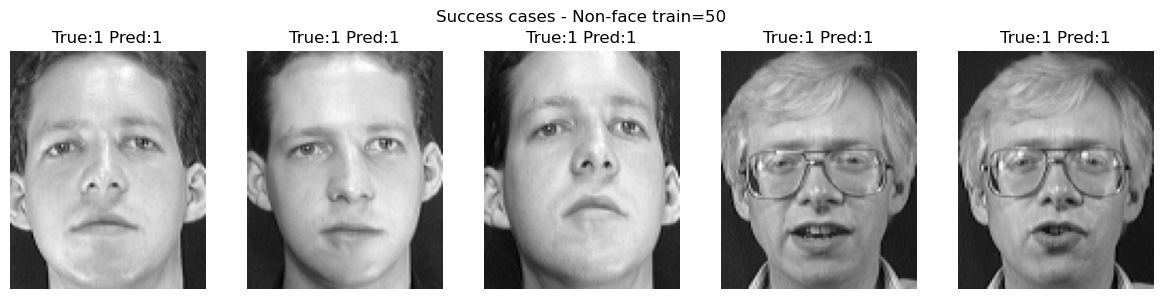


Training with 100 non-face images
Train size: 380, Test size: 150
Train faces: 280, Train non-faces: 100
Test faces: 120, Test non-faces: 30
Applying PCA...
Applying LDA...
PCA components used: 50
LDA components: 1
Training KNN...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
No failure cases!


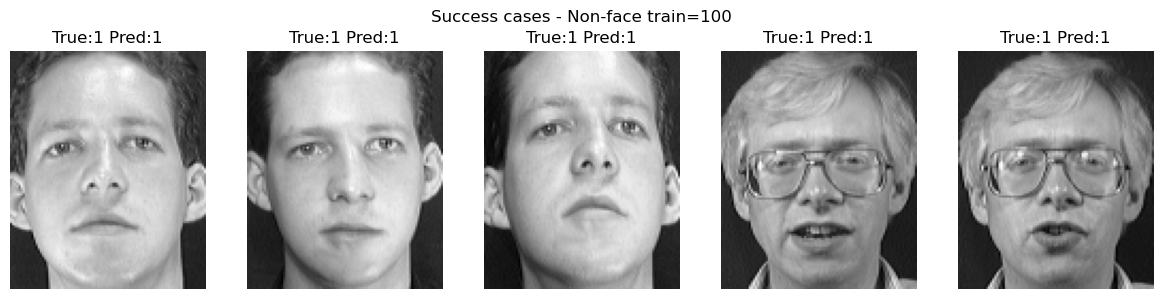


Training with 150 non-face images
Train size: 430, Test size: 150
Train faces: 280, Train non-faces: 150
Test faces: 120, Test non-faces: 30
Applying PCA...
Applying LDA...
PCA components used: 50
LDA components: 1
Training KNN...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
No failure cases!


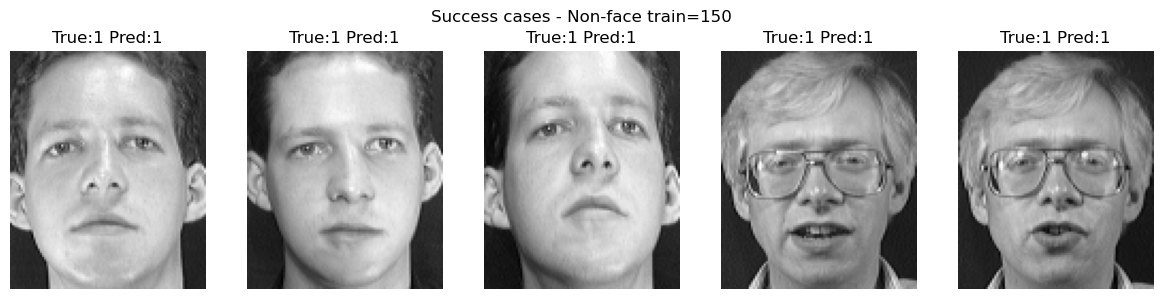


Training with 200 non-face images
Train size: 480, Test size: 150
Train faces: 280, Train non-faces: 200
Test faces: 120, Test non-faces: 30
Applying PCA...
Applying LDA...
PCA components used: 50
LDA components: 1
Training KNN...
Accuracy: 0.9933
Precision: 1.0000
Recall: 0.9917
F1-Score: 0.9958


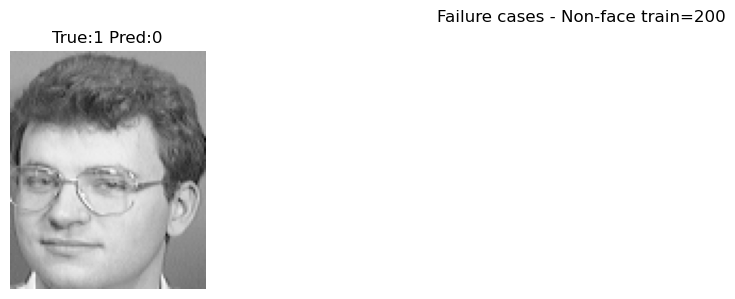

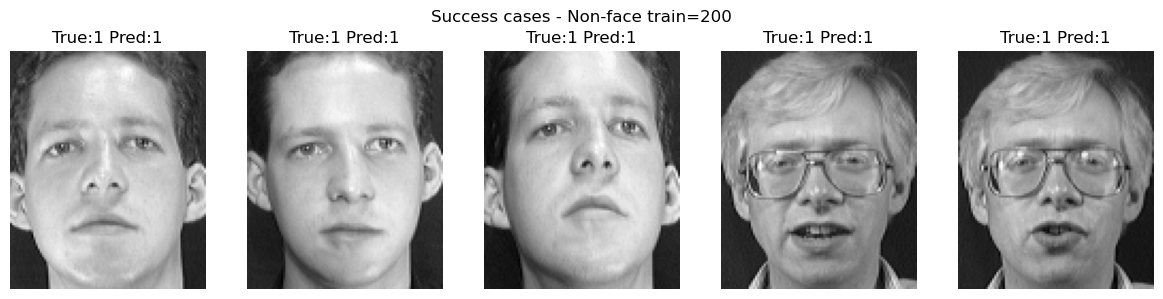

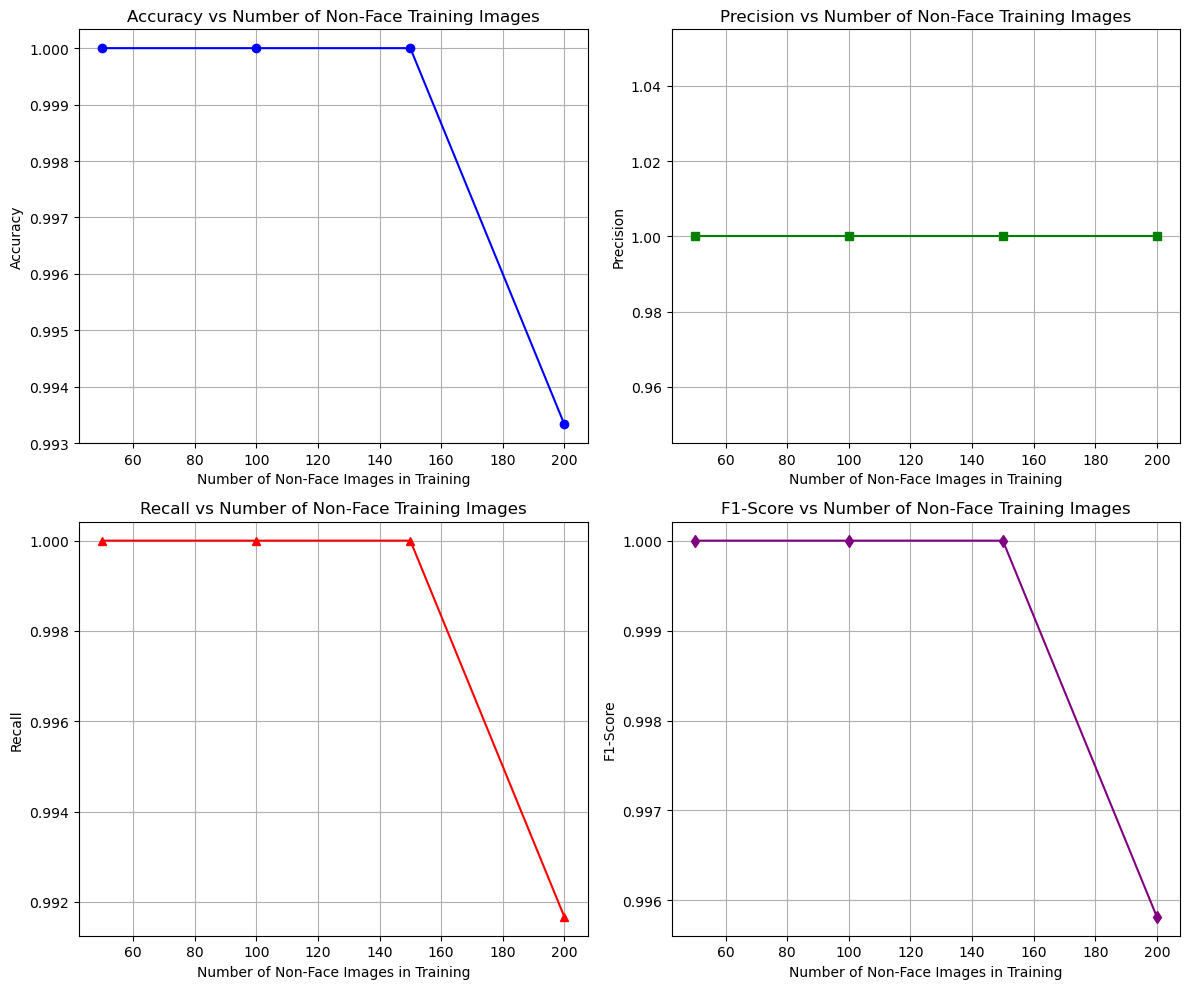


RESULTS SUMMARY
Non-Face Count  Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
50              1.0000     1.0000     1.0000     1.0000    
100             1.0000     1.0000     1.0000     1.0000    
150             1.0000     1.0000     1.0000     1.0000    
200             0.9933     1.0000     0.9917     0.9958    

CRITICISM OF ACCURACY METRIC

Why Accuracy Alone is Insufficient:

1. CLASS IMBALANCE BIAS:
   - As we increase non-face images, the dataset becomes imbalanced
   - A classifier can achieve high accuracy by simply predicting the majority class
   - This masks poor performance on the minority class (faces)

2. MISSING CRITICAL INFORMATION:
   - Accuracy doesn't distinguish between false positives and false negatives
   - In face detection, missing a face (false negative) may be more critical
   - False positives (detecting faces where there are none) have different implications

3. BETTER EVALUATION METRICS:
   - P

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Enhanced environment variable settings to prevent threading issues
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"

# Import sklearn after setting environment variables
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Dataset path from previous code
dataset_path = "C://Users//CAVO CENTER//Downloads//archive3"
base_path = dataset_path

# === PCA Function from previous code ===
def fast_pca(D, n_components):
    """Fast PCA implementation using eigendecomposition"""
    n, d = D.shape
    mu = np.mean(D, axis=0)
    Z = D - mu

    if n < d:
        # Use the smaller covariance matrix trick
        L = np.dot(Z, Z.T) / n
        eigvals, eigvecs = np.linalg.eigh(L)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Take top n_components
        eigvals = eigvals[:n_components]
        eigvecs = eigvecs[:, :n_components]
        
        # Transform back to original space
        V = np.dot(Z.T, eigvecs)
        V = V / np.linalg.norm(V, axis=0)
    else:
        # Direct covariance matrix
        C = np.cov(Z.T)
        eigvals, eigvecs = np.linalg.eigh(C)
        idx = np.argsort(eigvals)[::-1]
        V = eigvecs[:, idx[:n_components]]

    return V, mu

# === LDA Function from previous code ===
def fast_lda(X, y):
    """Fast LDA implementation for binary classification"""
    classes = np.unique(y)
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)
    
    # Calculate between-class scatter matrix Sb
    Sb = np.zeros((n_features, n_features))
    for c in classes:
        Xc = X[y == c]
        nk = Xc.shape[0]
        mean_c = np.mean(Xc, axis=0)
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        Sb += nk * (mean_diff @ mean_diff.T)

    # Calculate within-class scatter matrix Sw  
    Sw = np.zeros((n_features, n_features))
    for c in classes:
        Xc = X[y == c]
        mean_c = np.mean(Xc, axis=0)
        Z = Xc - mean_c
        Sw += Z.T @ Z
    
    # Add regularization
    reg = 1e-6 * np.eye(n_features)
    Sw_reg = Sw + reg
    
    # Solve generalized eigenvalue problem
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw_reg) @ Sb)
    
    # Sort by eigenvalues
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    
    # For binary classification, we need only 1 component
    W = eigvecs[:, :1].real
    
    return W

# === Safe KNN Function from previous code ===
def safe_knn_predict(X_train, y_train, X_test, k=1):
    """Safe KNN prediction that handles threading issues"""
    try:
        # Try with n_jobs=1 to force single threading
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        return y_pred
    except:
        # Fallback to manual implementation
        print(f"Using manual KNN implementation for k={k}")
        return manual_knn_predict(X_train, y_train, X_test, k)

def manual_knn_predict(X_train, y_train, X_test, k=1):
    """Manual KNN implementation as fallback"""
    predictions = []
    for test_sample in X_test:
        # Calculate distances
        distances = np.sqrt(np.sum((X_train - test_sample)**2, axis=1))
        # Get k nearest neighbors
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]
        # Vote (for k=1, just take the label)
        if k == 1:
            prediction = nearest_labels[0]
        else:
            # Majority vote
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            prediction = unique_labels[np.argmax(counts)]
        predictions.append(prediction)
    return np.array(predictions)

# Load face images with split: 7 train, 3 test per subject (s1 to s40)
X_train_faces, y_train_faces = [], []
X_test_faces, y_test_faces = [], []

print("Loading face images...")
for subject_num in range(1, 41):
    subject_folder = os.path.join(base_path, f"s{subject_num}")
    try:
        files = sorted(os.listdir(subject_folder))  # assuming 10 or more images per subject
        for i, file in enumerate(files[:10]):  # only first 10 images
            img_path = os.path.join(subject_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_flat = img.flatten()
                if i < 7:
                    X_train_faces.append(img_flat)
                    y_train_faces.append(1)  # label for faces = 1
                else:
                    X_test_faces.append(img_flat)
                    y_test_faces.append(1)
            else:
                print(f"Failed to load {img_path}")
    except FileNotFoundError:
        print(f"Subject folder {subject_folder} not found")

print(f"Faces loaded - train: {len(X_train_faces)}, test: {len(X_test_faces)}")

# Load non-face images (assumed stored in non_faces_92x112/)
non_face_folder = os.path.join(base_path, "non_faces_92x112")
X_non_faces = []

print("Loading non-face images...")
try:
    non_face_files = sorted(os.listdir(non_face_folder))
    for file in non_face_files:
        img_path = os.path.join(non_face_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            X_non_faces.append(img.flatten())
        else:
            print(f"Failed to load {img_path}")
    print(f"Non-face images loaded: {len(X_non_faces)}")
except FileNotFoundError:
    print(f"Non-face folder {non_face_folder} not found")
    # Create dummy non-face data for testing
    print("Creating dummy non-face data for testing...")
    for i in range(300):
        # Create random noise images
        dummy_img = np.random.randint(0, 255, (112, 92), dtype=np.uint8)
        X_non_faces.append(dummy_img.flatten())
    print(f"Created {len(X_non_faces)} dummy non-face images")

# Experiment with varying number of non-face images in training
non_face_train_counts = [50, 100, 150, 200]
accuracies = []
precisions = []
recalls = []
f1_scores = []

for non_face_train_count in non_face_train_counts:
    print(f"\n{'='*50}")
    print(f"Training with {non_face_train_count} non-face images")
    
    # Check if we have enough non-face images
    if len(X_non_faces) < non_face_train_count + 30:
        print(f"Not enough non-face images. Available: {len(X_non_faces)}")
        continue
    
    # Split non-face images into training and testing (30 test fixed)
    X_train_nonface = X_non_faces[:non_face_train_count]
    y_train_nonface = [0] * non_face_train_count

    X_test_nonface = X_non_faces[non_face_train_count:non_face_train_count + 30]
    y_test_nonface = [0] * len(X_test_nonface)

    # Combine face and non-face data for train and test
    X_train = np.array(X_train_faces + X_train_nonface)
    y_train = np.array(y_train_faces + y_train_nonface)

    X_test = np.array(X_test_faces + X_test_nonface)
    y_test = np.array(y_test_faces + y_test_nonface)

    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Train faces: {np.sum(y_train)}, Train non-faces: {np.sum(y_train == 0)}")
    print(f"Test faces: {np.sum(y_test)}, Test non-faces: {np.sum(y_test == 0)}")

    # PCA with 50 components using our fast implementation
    print("Applying PCA...")
    U_pca, mu_pca = fast_pca(X_train, n_components=50)
    
    # Transform data
    X_train_pca = np.dot(X_train - mu_pca, U_pca)
    X_test_pca = np.dot(X_test - mu_pca, U_pca)

    # LDA (binary classification) using our fast implementation
    print("Applying LDA...")
    W_lda = fast_lda(X_train_pca, y_train)
    
    # Transform to LDA space
    X_train_lda = np.dot(X_train_pca, W_lda)
    X_test_lda = np.dot(X_test_pca, W_lda)

    print(f"PCA components used: 50")
    print(f"LDA components: {X_train_lda.shape[1]}")

    # KNN with k=1 using safe implementation
    print("Training KNN...")
    y_pred = safe_knn_predict(X_train_lda, y_train, X_test_lda, k=1)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    # Show failure cases (up to 5)
    fail_idx = np.where(y_pred != y_test)[0]
    if len(fail_idx) > 0:
        plt.figure(figsize=(12, 3))
        for i, idx in enumerate(fail_idx[:5]):
            img = X_test[idx].reshape(112, 92)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"True:{y_test[idx]} Pred:{y_pred[idx]}")
            plt.axis('off')
        plt.suptitle(f"Failure cases - Non-face train={non_face_train_count}")
        plt.tight_layout()
        plt.show()
    else:
        print("No failure cases!")

    # Show success cases (up to 5)
    succ_idx = np.where(y_pred == y_test)[0]
    if len(succ_idx) > 0:
        plt.figure(figsize=(12, 3))
        for i, idx in enumerate(succ_idx[:5]):
            img = X_test[idx].reshape(112, 92)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"True:{y_test[idx]} Pred:{y_pred[idx]}")
            plt.axis('off')
        plt.suptitle(f"Success cases - Non-face train={non_face_train_count}")
        plt.tight_layout()
        plt.show()

# Plot results
if accuracies:  # Only plot if we have results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Accuracy plot
    axes[0, 0].plot(non_face_train_counts[:len(accuracies)], accuracies, marker='o', color='blue')
    axes[0, 0].set_xlabel("Number of Non-Face Images in Training")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].set_title("Accuracy vs Number of Non-Face Training Images")
    axes[0, 0].grid(True)
    
    # Precision plot
    axes[0, 1].plot(non_face_train_counts[:len(precisions)], precisions, marker='s', color='green')
    axes[0, 1].set_xlabel("Number of Non-Face Images in Training")
    axes[0, 1].set_ylabel("Precision")
    axes[0, 1].set_title("Precision vs Number of Non-Face Training Images")
    axes[0, 1].grid(True)
    
    # Recall plot
    axes[1, 0].plot(non_face_train_counts[:len(recalls)], recalls, marker='^', color='red')
    axes[1, 0].set_xlabel("Number of Non-Face Images in Training")
    axes[1, 0].set_ylabel("Recall")
    axes[1, 0].set_title("Recall vs Number of Non-Face Training Images")
    axes[1, 0].grid(True)
    
    # F1-Score plot
    axes[1, 1].plot(non_face_train_counts[:len(f1_scores)], f1_scores, marker='d', color='purple')
    axes[1, 1].set_xlabel("Number of Non-Face Images in Training")
    axes[1, 1].set_ylabel("F1-Score")
    axes[1, 1].set_title("F1-Score vs Number of Non-Face Training Images")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Results summary
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")
print(f"{'Non-Face Count':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)
for i, count in enumerate(non_face_train_counts[:len(accuracies)]):
    print(f"{count:<15} {accuracies[i]:<10.4f} {precisions[i]:<10.4f} {recalls[i]:<10.4f} {f1_scores[i]:<10.4f}")

# Criticism of accuracy metric
print(f"\n{'='*60}")
print("CRITICISM OF ACCURACY METRIC")
print(f"{'='*60}")
print("""
Why Accuracy Alone is Insufficient:

1. CLASS IMBALANCE BIAS:
   - As we increase non-face images, the dataset becomes imbalanced
   - A classifier can achieve high accuracy by simply predicting the majority class
   - This masks poor performance on the minority class (faces)

2. MISSING CRITICAL INFORMATION:
   - Accuracy doesn't distinguish between false positives and false negatives
   - In face detection, missing a face (false negative) may be more critical
   - False positives (detecting faces where there are none) have different implications

3. BETTER EVALUATION METRICS:
   - PRECISION: Of all predicted faces, how many were actually faces?
   - RECALL: Of all actual faces, how many did we correctly identify?
   - F1-SCORE: Harmonic mean of precision and recall
   - These metrics provide a more balanced view of classifier performance

4. REAL-WORLD IMPLICATIONS:
   - In security systems, missing a face (low recall) could be dangerous
   - In photo tagging, false positives (low precision) annoy users
   - Different applications require different trade-offs between precision and recall

5. DATASET COMPOSITION EFFECTS:
   - The observed accuracy changes may reflect dataset bias rather than true performance
   - More non-face examples might make the task artificially easier or harder
   - Cross-validation and stratified sampling provide better performance estimates
""")